# DeepLearning Term Project

#### Presented by: Melisa Vadenja, Tirdod Behbehani


## 1. Introduction

In this project we develop a deep learning pipeline for detecting and segmenting tumors in brain MRI scans by training a Convolutional Neural Network (CNN) to classify scans as tumor or non-tumor and use a segmentation model to indicate the different tumor regions. (Add more here)

## 2. Methodology

Our dataset includes ***(how many?) MRI scans with tumor presence labels and corresponding ground-truth segmentation masks. In addition to traditional segmentation, we incorporate Meta’s Segment Anything Model (SAM) to generate automated masks. We integrate Meta’s Segment Anything Model (SAM) to generate automated segmentation masks and evaluate the alignment with the provided ground-truth masks. The objective is to assess whether SAM can reliably automate the tumor segmentation process. Additionally, we analyze the impact of using SAM-generated masks as training data for the CNN instead of manually annotated ones by measuring the potential drop in classification accuracy when the CNN is trained on SAM-derived masks compared to the original ground-truth labels, determining if this segmentation could be a good alternative to manual masking.



## 3. Dataset

In [11]:
!pip install kagglehub


Dont have to run twice.

In [12]:
import kagglehub

path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Melisa\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1


# 3. Dataset Description

IN this project used the Brain Tumor Segmentation (BraTS) 2020 dataset which is a collection of MRI scans used for  brain tumor segmentation.

According to the dataset description, it includes MRI scans from glioma patients. Each of these patients are represented in the dataset with 4 different MRI imagings named as : Native (T1), Post-contrast T1-weighted (T1ce),T2-weighted (T2), T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery) and all of these are annotated by doctors in such a way that borders the tumor in its regions, represented with these labes in the dataset:
  1. **Label 0**: Not Tumor (NT)
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing
  5. **Label 4**: GD-enhancing tumor (ET)

However no MRIs in the dataset include label 3.

The way the dataset is structured is into training and testing data where the patients are represented inside of folders as folders themselves.


# 4. Exploratory data analysis.

In [13]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import nibabel as nib
import keras
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


In [14]:
!pip install matplotlib nibabel scikit-image tensorflow keras scikit-learn

In [15]:
train_path = path + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [16]:
# the images are in nii format, we will use nibabel to read them and then convert them to numpy arrays
flair_test_image = nib.load(train_path + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", flair_test_image.shape)
print("Dtype: ", flair_test_image.dtype)

# WE ARE INTERESTED IN THEIR SHAPE BCS WE WANT THEM TO SHARE A SIZE AND ALSO WE WILL RESIZE THEM TO FIT THE CNN LATER.

Shape:  (240, 240, 155)
Dtype:  float64


In [17]:
type(flair_test_image)

numpy.memmap

In [18]:
flair_test_image = np.array(flair_test_image)
type(flair_test_image)

numpy.ndarray

In [19]:
print("Minimum pixel value: ", flair_test_image.min())
print("Maximum pixel value: ", flair_test_image.max())
# this is good to know dor rescaling the images later and bcs we  want standardized images across all 4 types of
# MRI scans.

Minimum pixel value:  0.0
Maximum pixel value:  1854.603271484375


In [20]:
scaler = MinMaxScaler()

#### the previous code (some_image = scaler.fit_transform(some_image.reshape(-1, some_image.shape[-1])).reshape(some_image.shape)) may  have been performing incorrect normalization.

It was performing row-wise normalization, which can lead to slice inconsistency. If one slice happens to have higher intensities overall than another, it will still end up with a similar range after scaling. That can disrupt global intensity relationships between slices, which can be problematic for many 3D tasks (especially in medical imaging).


The corrected code uses global normalization - which maintains a single, consistent intensity mapping across the entire volume of the image, which is crucial for detecting and delineating tumors that may span many slices. It is preferred when you want the entire 3d image on the same intensity scale.

In [21]:
# we flatten, then fit a scaler to it and then turn it back into array bcs we want to normalize the pixel values but retain the image
flair_test_image = scaler.fit_transform(flair_test_image.reshape(-1, 1)).reshape(flair_test_image.shape)

In [22]:
print("Min: ", flair_test_image.min())
print("Max: ", flair_test_image.max())

Min:  0.0
Max:  1.0


In [23]:
# rescaling t1
test_image_t1 = nib.load(train_path + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, 1)).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(train_path + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, 1)).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(train_path + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, 1)).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(train_path + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


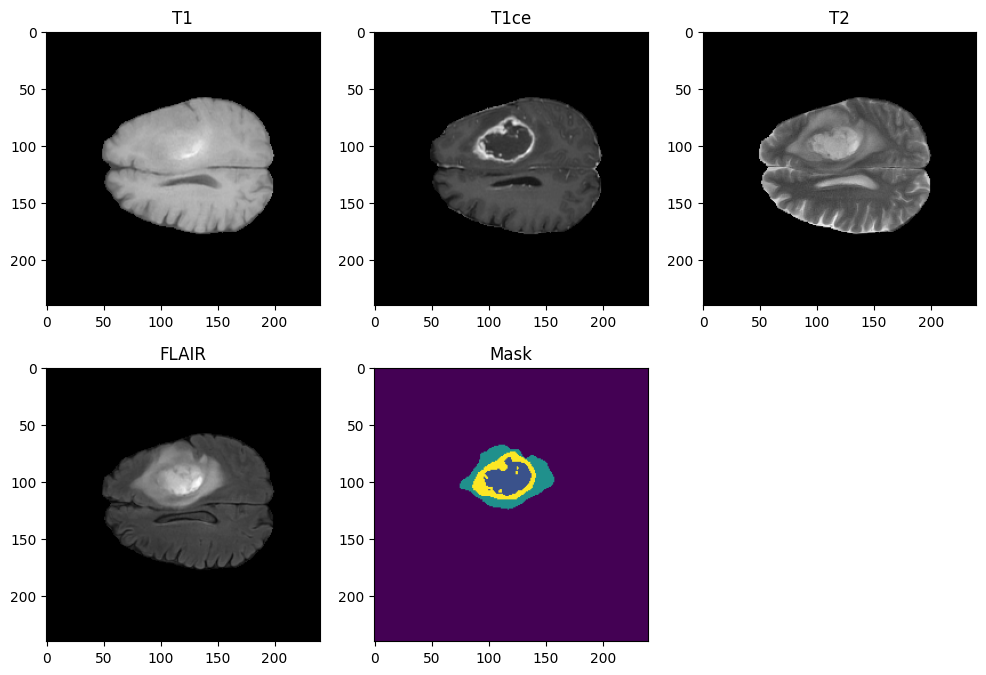

In [24]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(flair_test_image[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

In [25]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


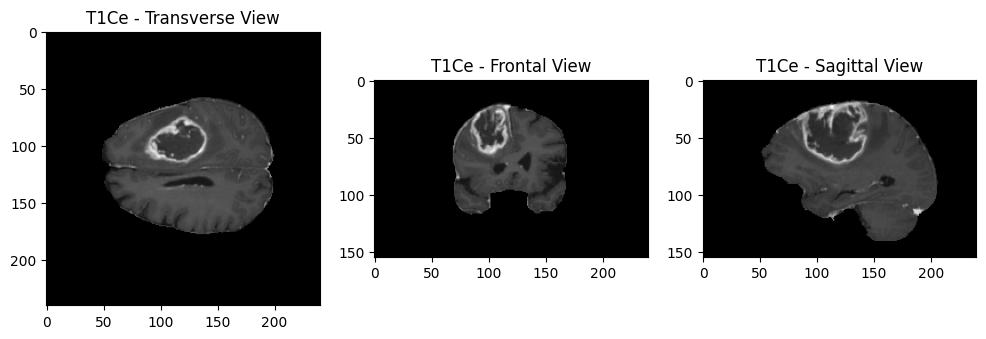

In [26]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1Ce - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1Ce - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1Ce - Sagittal View')
plt.show()

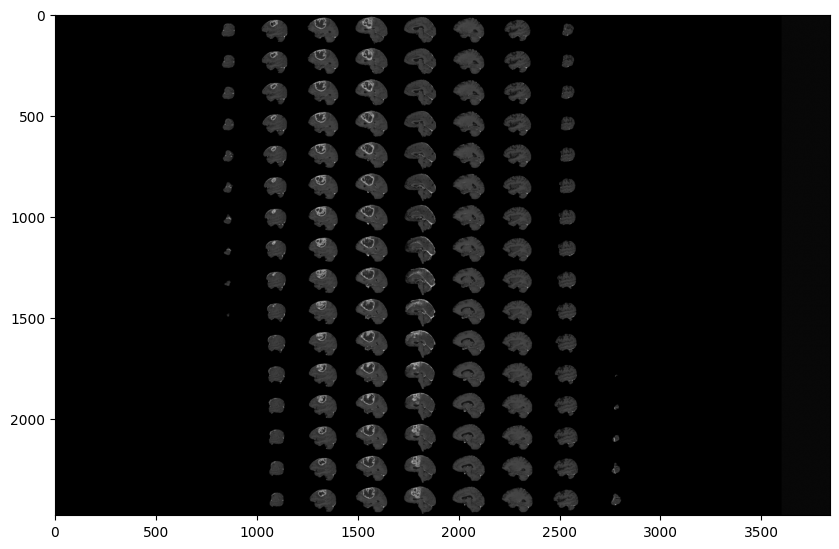

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

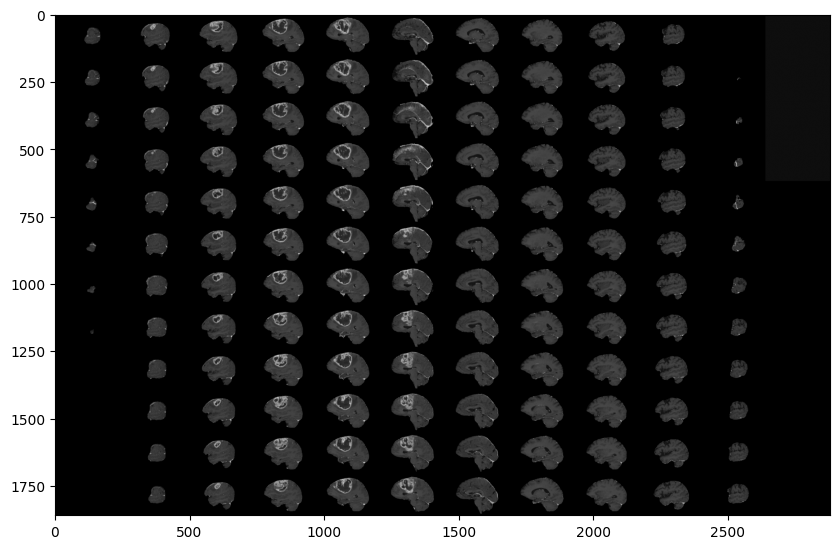

In [28]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray')

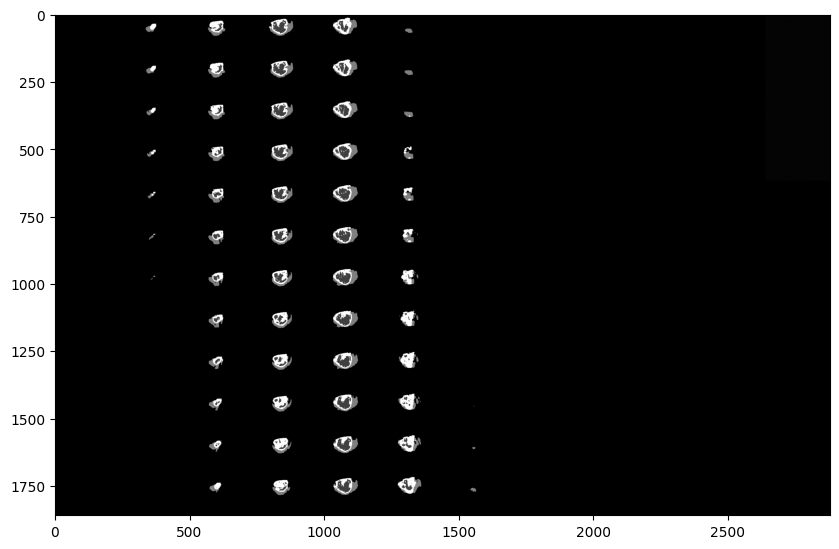

In [29]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

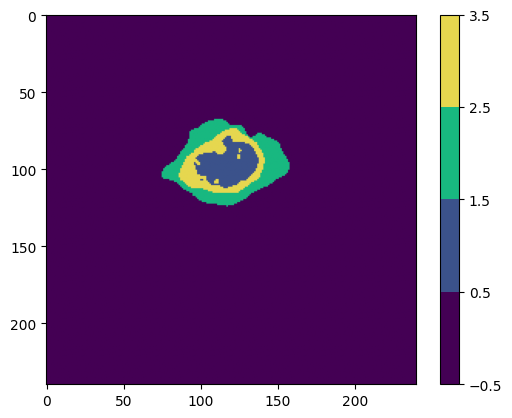

In [30]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

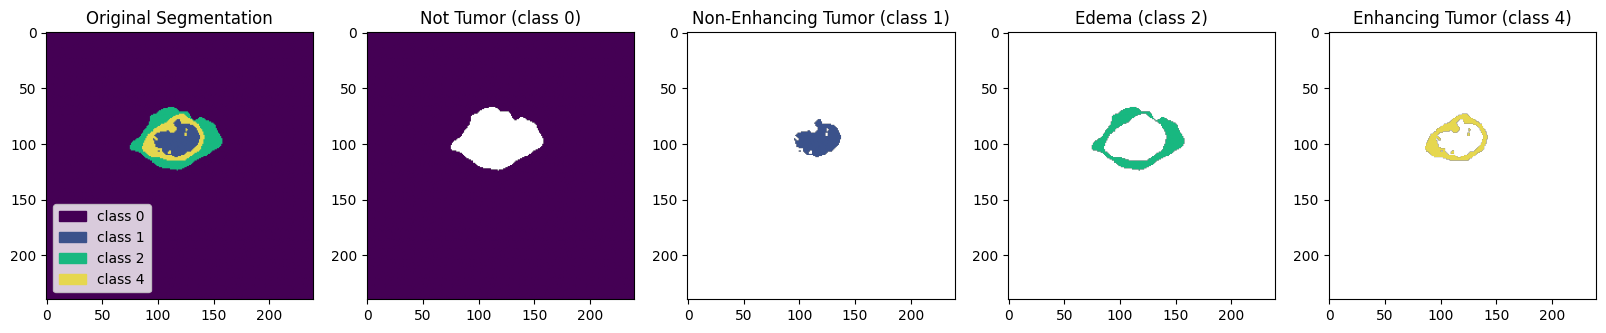

In [31]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

In [32]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(train_path) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [33]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


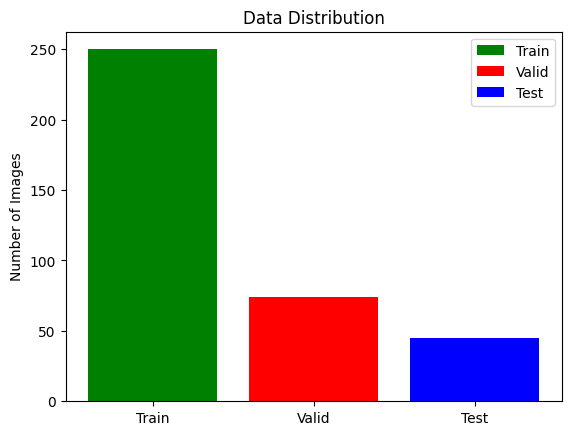

In [34]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

In [35]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [36]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch"""
        return int(np.floor(len(self.indexes) / self.batch_size))  # Ensure this is > 0

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):

        # Initialization with float32 dtype
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240), dtype=np.uint8)  # Ensure labels are int
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_path, i)

            # Load images
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            # Resize and store slices
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Convert segmentation labels (4 → 3)
        y[y == 4] = 3

        # One-hot encode segmentation masks
        mask = tf.one_hot(y, 4, dtype=tf.float32)  # Ensure float32 dtype
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)).numpy()  # Convert to NumPy

        # Normalize `X`, ensuring no division by zero
        X_max = np.max(X)
        if X_max > 0:
            X /= X_max

        return X, Y  # Both as NumPy arrays

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

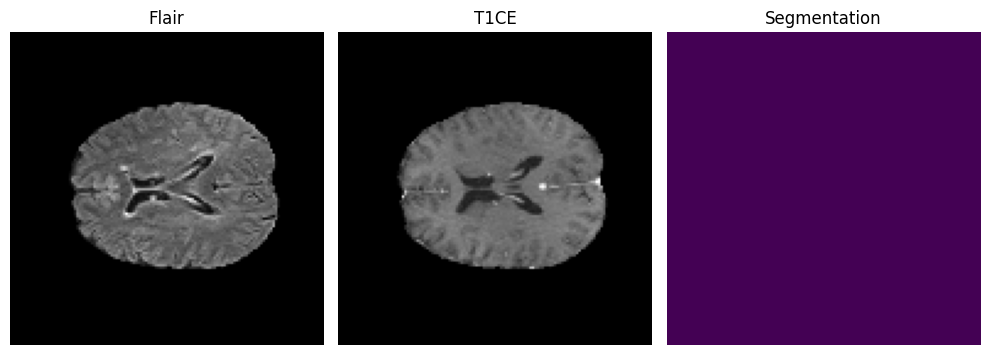

In [37]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


In [38]:
!pip install torchmetrics

In [39]:
import os
import cv2
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm

# CUDA Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
VOLUME_SLICES = 100
VOLUME_START_AT = 22
IMG_SIZE = 128
NUM_CLASSES = 4
BATCH_SIZE = 8
EPOCHS = 10


Using device: cuda


In [40]:
import os
import cv2
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, patient_folders, img_size=128, volume_slices=100, volume_start=22):
        """
        Args:
            root_dir (str): Path to the dataset root directory.
            patient_folders (list): List of patient folder names.
            img_size (int): Image size after resizing.
            volume_slices (int): Number of slices per MRI scan.
            volume_start (int): Start index for slicing.
        """
        self.root_dir = root_dir
        self.patient_folders = patient_folders
        self.img_size = img_size
        self.volume_slices = volume_slices
        self.volume_start = volume_start
        self.total_slices = len(self.patient_folders) * self.volume_slices  # Total dataset size

    def __len__(self):
        return self.total_slices

    def __getitem__(self, idx):
        """
        Loads and returns an MRI slice with segmentation label.
        """
        # Compute patient index and slice index
        patient_idx = idx // self.volume_slices
        slice_idx = idx % self.volume_slices

        # Get patient folder path
        patient_id = self.patient_folders[patient_idx]
        patient_path = os.path.join(self.root_dir, patient_id)

        # **Ensure the directory exists**
        assert os.path.isdir(patient_path), f"Directory not found: {patient_path}"

        try:
            # Load MRI modalities & segmentation mask
            flair_path = os.path.join(patient_path, f"{patient_id}_flair.nii")
            t1ce_path = os.path.join(patient_path, f"{patient_id}_t1ce.nii")
            seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")

            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

        except Exception as e:
            print(f"Error loading case {patient_id}: {e}")
            return torch.zeros((2, self.img_size, self.img_size)), torch.zeros((self.img_size, self.img_size), dtype=torch.long)

        # Select and resize slice
        try:
            flair_slice = cv2.resize(flair[:, :, slice_idx + self.volume_start], (self.img_size, self.img_size))
            t1ce_slice = cv2.resize(t1ce[:, :, slice_idx + self.volume_start], (self.img_size, self.img_size))
            seg_slice = cv2.resize(seg[:, :, slice_idx + self.volume_start], (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        except:
            print(f"Error resizing images for patient {patient_id}, slice {slice_idx}")
            return torch.zeros((2, self.img_size, self.img_size)), torch.zeros((self.img_size, self.img_size), dtype=torch.long)

        # Convert segmentation labels (4 → 3 for consistency)
        seg_slice[seg_slice == 4] = 3

        # Normalize input images
        flair_slice = flair_slice / np.max(flair_slice) if np.max(flair_slice) > 0 else flair_slice
        t1ce_slice = t1ce_slice / np.max(t1ce_slice) if np.max(t1ce_slice) > 0 else t1ce_slice

        # Stack input channels (2-channel input)
        X = np.stack([flair_slice, t1ce_slice], axis=0)
        Y = torch.tensor(seg_slice, dtype=torch.long)  # Segmentation mask

        return torch.tensor(X, dtype=torch.float32), Y


In [41]:
# Define dataset root directory (string)
train_path = "C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Get list of patient folder names (not full paths!)
patient_folders = [f.name for f in os.scandir(train_path) if f.is_dir()]

# Split into train & validation
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(patient_folders, test_size=0.2)

# Initialize datasets (pass train_path as string, not list)
train_dataset = BrainTumorDataset(train_path, train_ids)
val_dataset = BrainTumorDataset(train_path, val_ids)

# ✅ Now, `train_dataset[0]` should work fine
sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)  # Expected: (2, 128, 128)
print("Mask shape:", sample_mask.shape)  # Expected: (128, 128)
print("train_path:", train_path)  # Should be a string

# Get list of patient folders (not full paths, just names)
patient_folders = [f.name for f in os.scandir(train_path) if f.is_dir()]
print("Example patient folder names:", patient_folders[:5])  # Should be a list of strings

# Check if train_path is a string and patient_folders is a list
assert isinstance(train_path, str), f"❌ train_path is not a string: {type(train_path)}"
assert isinstance(patient_folders, list), f"❌ patient_folders is not a list: {type(patient_folders)}"
assert isinstance(patient_folders[0], str), f"❌ patient_folders contains non-string: {type(patient_folders[0])}"

print("✅ train_path is a string and patient_folders is a list of strings.")


Image shape: torch.Size([2, 128, 128])
Mask shape: torch.Size([128, 128])
train_path: C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/
Example patient folder names: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']
✅ train_path is a string and patient_folders is a list of strings.


In [42]:
train_path = "C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Verify type of train_path
print("Type of train_path:", type(train_path))  # Should be <class 'str'>

# Get list of patient folder names (not full paths!)
patient_folders = [f.name for f in os.scandir(train_path) if f.is_dir()]
print("Type of patient_folders:", type(patient_folders))
print("Example patient folder name:", patient_folders[0])


Type of train_path: <class 'str'>
Type of patient_folders: <class 'list'>
Example patient folder name: BraTS20_Training_001


In [43]:
from sklearn.model_selection import train_test_split

# Split patient_folders (list of strings) into train and validation sets.
train_ids, val_ids = train_test_split(patient_folders, test_size=0.2)

# Initialize the dataset with train_path (string) and train_ids (list of strings)
train_dataset = BrainTumorDataset(train_path, train_ids)
val_dataset = BrainTumorDataset(train_path, val_ids)


In [50]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [36]:

model = ResUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------
# 1) Residual Double-Conv Block (mimics two consecutive convs in Keras, but with a residual connection)
# -------------------
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ResidualDoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)

        # If input and output channels differ, we match dimensions with a 1x1 conv
        self.shortcut = None
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)

        # Optional dropout (used in the bottleneck to match Keras dropout)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        shortcut = x if self.shortcut is None else self.shortcut(x)
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = self.dropout(out)  # only if dropout > 0 in this block
        out = out + shortcut
        out = F.relu(out)
        return out


# -------------------
# 2) Residual U-Net (mimicking your Keras architecture)
# -------------------
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=4, dropout=0.3):
        super(ResidualUNet, self).__init__()

        # ----------- Encoder -----------
        self.enc1 = ResidualDoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualDoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualDoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = ResidualDoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # ----------- Bottleneck (with dropout) -----------
        self.bottleneck = ResidualDoubleConv(256, 512, dropout=dropout)

        # ----------- Decoder -----------
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec5 = ResidualDoubleConv(256 + 256, 256)

        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec6 = ResidualDoubleConv(128 + 128, 128)

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec7 = ResidualDoubleConv(64 + 64, 64)

        self.up8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec8 = ResidualDoubleConv(32 + 32, 32)

        # Final output (raw logits)
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)

        c2 = self.enc2(p1)
        p2 = self.pool2(c2)

        c3 = self.enc3(p2)
        p3 = self.pool3(c3)

        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder
        u5 = self.up5(bn)
        merge5 = torch.cat([u5, c4], dim=1)
        d5 = self.dec5(merge5)

        u6 = self.up6(d5)
        merge6 = torch.cat([u6, c3], dim=1)
        d6 = self.dec6(merge6)

        u7 = self.up7(d6)
        merge7 = torch.cat([u7, c2], dim=1)
        d7 = self.dec7(merge7)

        u8 = self.up8(d7)
        merge8 = torch.cat([u8, c1], dim=1)
        d8 = self.dec8(merge8)

        out = self.out_conv(d8)
        return out  # raw logits (apply softmax outside if needed)


# -------------------
# 3) Weight Initialization (to replicate Keras's default or He Normal initialization)
# -------------------
def init_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


# -------------------
# 4) Example: Create and initialize the model
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # or tqdm.notebook, etc.

# -------------------------------
# 1) Setup your model & optimizer
# -------------------------------
model = ResidualUNet(in_channels=2, out_channels=4, dropout=0.3).to(device)
model.apply(init_weights_he)  # Kaiming/He initialization

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

# -------------------------------
# 2) Training & Validation Loop
# -------------------------------
for epoch in range(1, num_epochs + 1):

    # ======== TRAINING ========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Single progress bar for entire training set
    train_pbar = tqdm(train_loader,
                      desc=f"Epoch {epoch}/{num_epochs} [Training]",
                      leave=True)  # leave=True to keep the bar at epoch end

    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Pixel-wise accuracy
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == labels).sum().item()
        total = labels.numel()
        train_correct += correct
        train_total += total

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / train_total

    # ======== VALIDATION ========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Single progress bar for entire validation set
    val_pbar = tqdm(val_loader,
                    desc=f"Epoch {epoch}/{num_epochs} [Validation]",
                    leave=True)

    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            val_outputs = model(images)
            val_loss_batch = criterion(val_outputs, labels)
            val_loss += val_loss_batch.item() * images.size(0)

            val_preds = torch.argmax(val_outputs, dim=1)
            correct = (val_preds == labels).sum().item()
            total = labels.numel()
            val_correct += correct
            val_total += total

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    # ======== PRINT EPOCH METRICS ========
    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")

    # ======== SAVE MODEL CHECKPOINT ========
    torch.save(model.state_dict(), f"model2_epoch_{epoch}.pth")


Epoch 1/10 [Validation]: 100%|██████████| 925/925 [09:57<00:00,  1.55it/s]


Epoch 1/10 | Train Loss: 0.0369, Train Acc: 0.9883 | Val Loss: 0.0235,   Val Acc: 0.9921


Epoch 2/10 [Validation]: 100%|██████████| 925/925 [09:45<00:00,  1.58it/s]


Epoch 2/10 | Train Loss: 0.0155, Train Acc: 0.9944 | Val Loss: 0.0201,   Val Acc: 0.9936


Epoch 3/10 [Validation]: 100%|██████████| 925/925 [09:34<00:00,  1.61it/s]


Epoch 3/10 | Train Loss: 0.0110, Train Acc: 0.9959 | Val Loss: 0.0200,   Val Acc: 0.9938


Epoch 4/10 [Validation]: 100%|██████████| 925/925 [09:36<00:00,  1.60it/s]


Epoch 4/10 | Train Loss: 0.0090, Train Acc: 0.9966 | Val Loss: 0.0225,   Val Acc: 0.9933


Epoch 5/10 [Validation]: 100%|██████████| 925/925 [09:33<00:00,  1.61it/s]


Epoch 5/10 | Train Loss: 0.0079, Train Acc: 0.9970 | Val Loss: 0.0236,   Val Acc: 0.9938


Epoch 6/10 [Validation]: 100%|██████████| 925/925 [09:41<00:00,  1.59it/s]


Epoch 6/10 | Train Loss: 0.0071, Train Acc: 0.9972 | Val Loss: 0.0210,   Val Acc: 0.9942


Epoch 7/10 [Validation]: 100%|██████████| 925/925 [09:42<00:00,  1.59it/s]


Epoch 7/10 | Train Loss: 0.0065, Train Acc: 0.9974 | Val Loss: 0.0215,   Val Acc: 0.9942


Epoch 8/10 [Validation]: 100%|██████████| 925/925 [09:44<00:00,  1.58it/s]


Epoch 8/10 | Train Loss: 0.0062, Train Acc: 0.9976 | Val Loss: 0.0225,   Val Acc: 0.9941


Epoch 9/10 [Validation]: 100%|██████████| 925/925 [09:48<00:00,  1.57it/s]


Epoch 9/10 | Train Loss: 0.0058, Train Acc: 0.9977 | Val Loss: 0.0250,   Val Acc: 0.9941


Epoch 10/10 [Validation]: 100%|██████████| 925/925 [09:30<00:00,  1.62it/s]

Epoch 10/10 | Train Loss: 0.0055, Train Acc: 0.9978 | Val Loss: 0.0233,   Val Acc: 0.9941


In [ ]:
sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)  # Expected: (2, 128, 128)
print("Mask shape:", sample_mask.shape)  # Expected: (128, 128)


Image shape: torch.Size([2, 128, 128])
Mask shape: torch.Size([128, 128])


In [ ]:
for images, labels in tqdm(train_loader):
    print("Batch Shape:", images.shape, labels.shape)
    break  # Just to check if data is being loaded


  0%|          | 0/3688 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 15812, 13780, 4708, 7588) exited unexpectedly

# 7. Loss Function and Evaluation Metrics

In [48]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

### Per Class Dice Coefficient Functions

These functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

- **dice_coef_necrotic:** Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.
  
- **dice_coef_edema:** Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.
  
- **dice_coef_enhancing:** Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [49]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

Each function includes a small constant (`epsilon`) to avoid division by zero.

In [50]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## dont change


Here is the visual representation of our model:

![U-Net%20%281%29.png](attachment:U-Net%20%281%29.png)

## Build and Plot the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 128  # Modify based on dataset
model = ResUNet(in_channels=2, out_channels=4).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Example Input
sample_input = torch.randn(1, 2, IMG_SIZE, IMG_SIZE).to(device)
output = model(sample_input)
print("Output shape:", output.shape)
print(device)# Should be (1, 4, IMG_SIZE, IMG_SIZE)


Output shape: torch.Size([1, 4, 128, 128])
cuda


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
IMG_SIZE = 128  # Modify based on your dataset
model = ResidualUNet(in_channels=2, out_channels=4).to(device)

# Define Loss Function (Equivalent to Categorical Crossentropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (Equivalent to Keras Adam Optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)



print("Model is ready and using:", device)


Model is ready and using: cuda


In [51]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

AttributeError: 'ResidualUNet' object has no attribute 'built'

## Set up callbacks

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),

    ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                    verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger('training.log', separator=',', append=False)
]

# 9. Train and Save the Model

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 35 epochs.

In [ ]:
x, y = next(iter(training_generator))  # Try getting one batch
print("Batch Shape:", x.shape, y.shape)

Batch Shape: (100, 128, 128, 2) (100, 128, 128, 4)


In [ ]:
x, y = training_generator.__getitem__(0)  # Get first batch
print("Batch Shape (X):", x.shape)
print("Batch Shape (Y):", y.shape)
print("Data Type (X):", x.dtype)
print("Data Type (Y):", y.dtype)

Batch Shape (X): (100, 128, 128, 2)
Batch Shape (Y): (100, 128, 128, 4)
Data Type (X): float32
Data Type (Y): float32


In [ ]:
y_test = np.argmax(y, axis=-1)  # Convert back from one-hot
print("Unique labels in batch Y:", np.unique(y_test))  # Should be [0,1,2,3]

Unique labels in batch Y: [0 1 2 3]


In [ ]:
K.clear_session()
from tqdm.keras import TqdmCallback  # Progress bar for Keras

from tqdm.keras import TqdmCallback  # Add progress bar

history = model.fit(
    training_generator,  # Use optimized dataset
    epochs=10,
    steps_per_epoch=len(training_generator),
    callbacks=[TqdmCallback(), *callbacks],
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
174/250 ━━━━━━━━━━━━━━━━━━━━ 54s 718ms/step - accuracy: 0.9467 - dice_coef: 0.3241 - dice_coef_edema: 0.2662 - dice_coef_enhancing: 0.2101 - dice_coef_necrotic: 0.0976 - loss: 0.5587 - mean_io_u_1: 0.4478 - precision: 0.9465 - sensitivity: 0.9420 - specificity: 0.9839

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: No such file or no access: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/nibabel/loadsave.py", line 101, in load
    stat_result = os.stat(filename)
                  ^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "<ipython-input-95-e62a9ccc78d0>", line 25, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-95-e62a9ccc78d0>", line 49, in __data_generation
    seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/nibabel/loadsave.py", line 103, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")

FileNotFoundError: No such file or no access: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: No such file or no access: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/nibabel/loadsave.py", line 101, in load
    stat_result = os.stat(filename)
                  ^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "<ipython-input-95-e62a9ccc78d0>", line 25, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-95-e62a9ccc78d0>", line 49, in __data_generation
    seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/nibabel/loadsave.py", line 103, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")

FileNotFoundError: No such file or no access: '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_22816]

In [ ]:
model.save("my_model.keras")

# 10. Load the Trained Model

We will load our trained neural network model using Keras. The `load_model` method allows us to reload the saved model, including custom metrics and loss functions we defined during training. Here’s how we do it:

In [51]:
import torch
import torch.nn.functional as F

# ------------------------------
# Multi-class Dice (average over classes)
# ------------------------------
def dice_coef_avg_torch(y_pred, y_true, num_classes=4, epsilon=1e-7):
    """
    Computes the average Dice coefficient over all classes.
    Expects y_pred and y_true as integer-label tensors of shape (B, H, W).
    """
    dice = 0.0
    for c in range(num_classes):
        y_pred_c = (y_pred == c).float()
        y_true_c = (y_true == c).float()
        intersection = torch.sum(y_pred_c * y_true_c)
        union = torch.sum(y_pred_c) + torch.sum(y_true_c)
        dice += (2 * intersection + epsilon) / (union + epsilon)
    return dice / num_classes

# ------------------------------
# Multi-class Precision
# ------------------------------
def precision_multi_torch(y_pred, y_true, num_classes=4, epsilon=1e-7):
    """
    Computes average precision over all classes.
    Expects y_pred and y_true as integer-label tensors of shape (B, H, W).
    """
    # Convert to one-hot: shape (B, H, W, C) then permute to (B, C, H, W)
    y_pred_onehot = F.one_hot(y_pred, num_classes=num_classes).permute(0, 3, 1, 2).float()
    y_true_onehot = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
    true_positives = (y_pred_onehot * y_true_onehot).sum(dim=(2, 3))
    predicted_positives = y_pred_onehot.sum(dim=(2, 3))
    prec = (true_positives + epsilon) / (predicted_positives + epsilon)
    return prec.mean().item()

# ------------------------------
# Multi-class Sensitivity (Recall)
# ------------------------------
def sensitivity_multi_torch(y_pred, y_true, num_classes=4, epsilon=1e-7):
    """
    Computes average sensitivity (recall) over all classes.
    """
    y_pred_onehot = F.one_hot(y_pred, num_classes=num_classes).permute(0, 3, 1, 2).float()
    y_true_onehot = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
    true_positives = (y_pred_onehot * y_true_onehot).sum(dim=(2, 3))
    possible_positives = y_true_onehot.sum(dim=(2, 3))
    sens = (true_positives + epsilon) / (possible_positives + epsilon)
    return sens.mean().item()

# ------------------------------
# Multi-class Specificity
# ------------------------------
def specificity_multi_torch(y_pred, y_true, num_classes=4, epsilon=1e-7):
    """
    Computes average specificity over all classes.
    """
    y_pred_onehot = F.one_hot(y_pred, num_classes=num_classes).permute(0, 3, 1, 2).float()
    y_true_onehot = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
    # True negatives: where both y_true and y_pred are 0
    TN = ((1 - y_true_onehot) * (1 - y_pred_onehot)).sum(dim=(2, 3))
    FP = ((1 - y_true_onehot) * y_pred_onehot).sum(dim=(2, 3))
    spec = (TN + epsilon) / (TN + FP + epsilon)
    return spec.mean().item()

# ------------------------------
# Per-Class Dice Coefficient
# ------------------------------
def dice_coef_class_torch(y_true, y_pred, class_index, num_classes=4, epsilon=1e-6):
    """
    Computes the Dice coefficient for a specific class.
    If y_true and y_pred are 3D (B, H, W) with integer labels,
    they are one-hot encoded to (B, C, H, W).
    """
    if y_true.dim() == 3:
        y_true = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
        y_pred = F.one_hot(y_pred, num_classes=num_classes).permute(0, 3, 1, 2).float()
    y_true_class = y_true[:, class_index, :, :]
    y_pred_class = y_pred[:, class_index, :, :]
    intersection = torch.sum(y_true_class * y_pred_class)
    denominator = torch.sum(torch.square(y_true_class)) + torch.sum(torch.square(y_pred_class))
    dice = (2.0 * intersection + epsilon) / (denominator + epsilon)
    return dice.item()

def dice_coef_necrotic_torch(y_true, y_pred, num_classes=4, epsilon=1e-6):
    """Dice coefficient for necrotic tissue (class index 1)."""
    return dice_coef_class_torch(y_true, y_pred, class_index=1, num_classes=num_classes, epsilon=epsilon)

def dice_coef_edema_torch(y_true, y_pred, num_classes=4, epsilon=1e-6):
    """Dice coefficient for edema (class index 2)."""
    return dice_coef_class_torch(y_true, y_pred, class_index=2, num_classes=num_classes, epsilon=epsilon)

def dice_coef_enhancing_torch(y_true, y_pred, num_classes=4, epsilon=1e-6):
    """Dice coefficient for enhancing tissue (class index 3)."""
    return dice_coef_class_torch(y_true, y_pred, class_index=3, num_classes=num_classes, epsilon=epsilon)

# ------------------------------
# Inference and Metric Calculation
# ------------------------------

# Load your trained model
# Make sure that your model, val_loader, device, and metric functions (e.g., dice_coef_avg_torch, etc.) are defined

# Initialize lists to store the metrics for each epoch
epochs = []
dice_list = []
precision_list = []
sensitivity_list = []
specificity_list = []
dice_nec_list = []
dice_edema_list = []
dice_enh_list = []

# Loop over epochs 1 to 10
for epoch in range(1, 11):
    # Construct the model path based on epoch
    model_path = f"model2_epoch_{epoch}.pth"
    print(f"Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Initialize accumulators for the metrics
    dice_sum = 0.0
    precision_sum = 0.0
    sensitivity_sum = 0.0
    specificity_sum = 0.0
    dice_necrotic_sum = 0.0
    dice_edema_sum = 0.0
    dice_enhancing_sum = 0.0
    count_batches = 0

    # Compute metrics over the validation set
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)         # shape: (B, in_channels, H, W)
            labels = labels.to(device).long()    # shape: (B, H, W)

            # Forward pass through the model
            logits = model(images)               # shape: (B, 4, H, W)
            preds = torch.argmax(logits, dim=1)    # shape: (B, H, W)

            # Compute metrics (assuming these functions are defined and work with integer labels)
            dice_batch = dice_coef_avg_torch(preds, labels, num_classes=4)
            prec_batch = precision_multi_torch(preds, labels, num_classes=4)
            sens_batch = sensitivity_multi_torch(preds, labels, num_classes=4)
            spec_batch = specificity_multi_torch(preds, labels, num_classes=4)
            dice_nec_batch = dice_coef_necrotic_torch(preds, labels, num_classes=4)
            dice_ede_batch = dice_coef_edema_torch(preds, labels, num_classes=4)
            dice_enh_batch = dice_coef_enhancing_torch(preds, labels, num_classes=4)

            dice_sum += dice_batch
            precision_sum += prec_batch
            sensitivity_sum += sens_batch
            specificity_sum += spec_batch
            dice_necrotic_sum += dice_nec_batch
            dice_edema_sum += dice_ede_batch
            dice_enhancing_sum += dice_enh_batch
            count_batches += 1

    # Calculate averaged metrics for the current epoch
    dice_avg = dice_sum / count_batches
    precision_avg = precision_sum / count_batches
    sensitivity_avg = sensitivity_sum / count_batches
    specificity_avg = specificity_sum / count_batches
    dice_nec_avg = dice_necrotic_sum / count_batches
    dice_ede_avg = dice_edema_sum / count_batches
    dice_enh_avg = dice_enhancing_sum / count_batches

    # Append metrics to our lists
    epochs.append(epoch)
    dice_list.append(dice_avg)
    precision_list.append(precision_avg)
    sensitivity_list.append(sensitivity_avg)
    specificity_list.append(specificity_avg)
    dice_nec_list.append(dice_nec_avg)
    dice_edema_list.append(dice_ede_avg)
    dice_enh_list.append(dice_enh_avg)

    # Print the metrics for the current epoch
    print(f"Epoch {epoch} Metrics:")
    print(f"  Dice Coeff (avg)     : {dice_avg:.4f}")
    print(f"  Precision (avg)      : {precision_avg:.4f}")
    print(f"  Sensitivity (avg)    : {sensitivity_avg:.4f}")
    print(f"  Specificity (avg)    : {specificity_avg:.4f}")
    print(f"  Dice Necrotic (avg)  : {dice_nec_avg:.4f}")
    print(f"  Dice Edema (avg)     : {dice_ede_avg:.4f}")
    print(f"  Dice Enhancing (avg) : {dice_enh_avg:.4f}")
    print("========================================")

# Save all the collected metrics in a dictionary for later plotting
all_metrics = {
    "epoch": epochs,
    "dice": dice_list,
    "precision": precision_list,
    "sensitivity": sensitivity_list,
    "specificity": specificity_list,
    "dice_necrotic": dice_nec_list,
    "dice_edema": dice_edema_list,
    "dice_enhancing": dice_enh_list
}

# Optionally, save the metrics dictionary to disk for later use:
torch.save(all_metrics, "validation_metrics.pth")


Loading model from: model2_epoch_1.pth


C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\260354395.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Epoch 1 Metrics:
  Dice Coeff (avg)     : 0.6610
  Precision (avg)      : 0.7716
  Sensitivity (avg)    : 0.8557
  Specificity (avg)    : 0.9621
  Dice Necrotic (avg)  : 0.5402
  Dice Edema (avg)     : 0.5516
  Dice Enhancing (avg) : 0.5542
Loading model from: model2_epoch_2.pth
Epoch 2 Metrics:
  Dice Coeff (avg)     : 0.7837
  Precision (avg)      : 0.8823
  Sensitivity (avg)    : 0.8752
  Specificity (avg)    : 0.9636
  Dice Necrotic (avg)  : 0.7271
  Dice Edema (avg)     : 0.6794
  Dice Enhancing (avg) : 0.7302
Loading model from: model2_epoch_3.pth
Epoch 3 Metrics:
  Dice Coeff (avg)     : 0.8164
  Precision (avg)      : 0.9043
  Sensitivity (avg)    : 0.8864
  Specificity (avg)    : 0.9700
  Dice Necrotic (avg)  : 0.7665
  Dice Edema (avg)     : 0.7026
  Dice Enhancing (avg) : 0.7979
Loading model from: model2_epoch_4.pth
Epoch 4 Metrics:
  Dice Coeff (avg)     : 0.8242
  Precision (avg)      : 0.9060
  Sensitivity (avg)    : 0.8895
  Specificity (avg)    : 0.9656
  Dice Necrotic

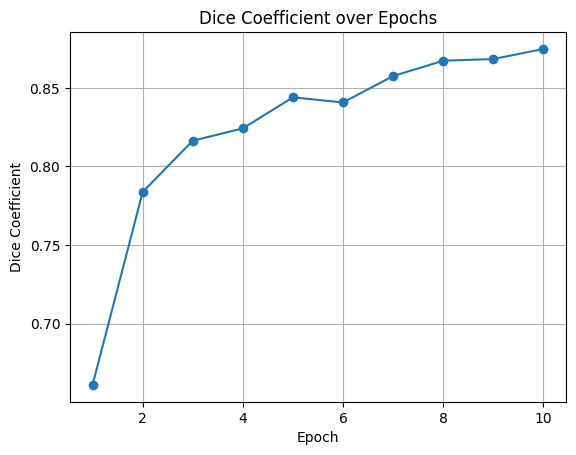

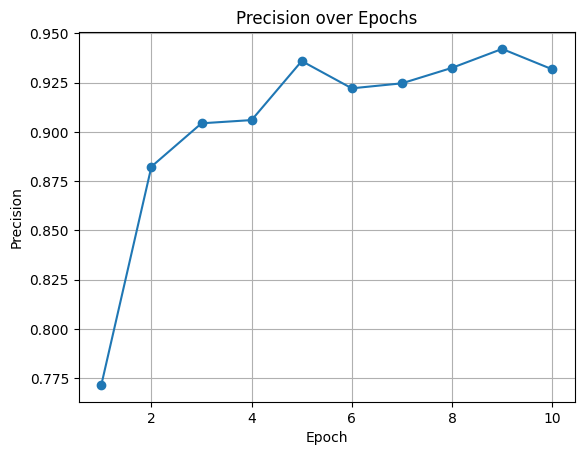

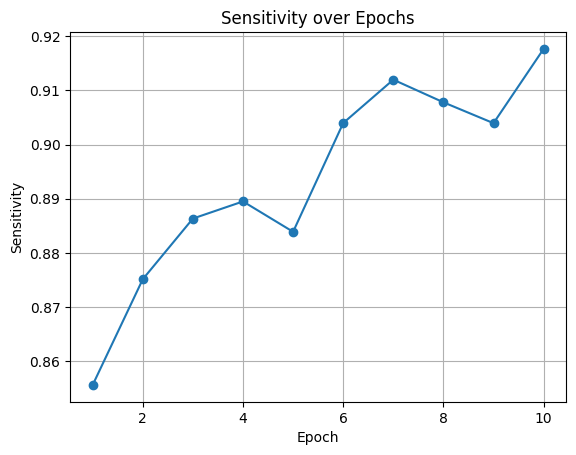

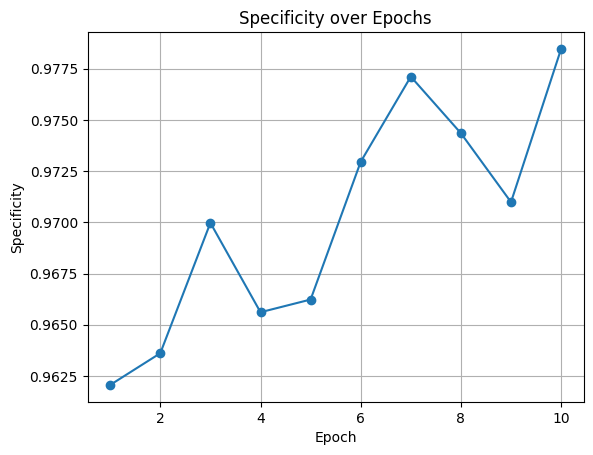

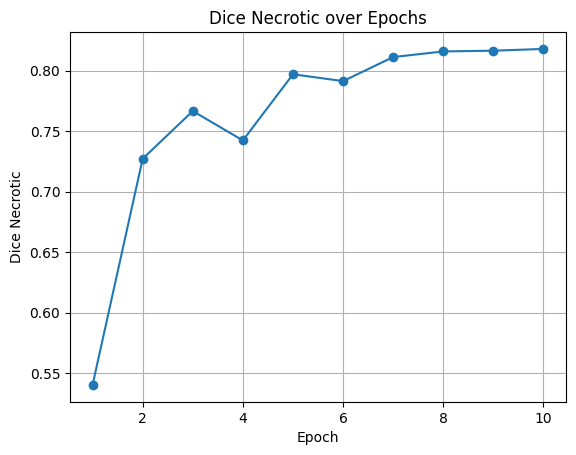

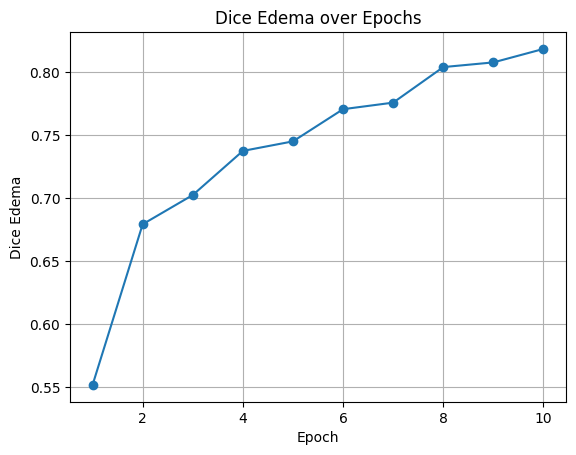

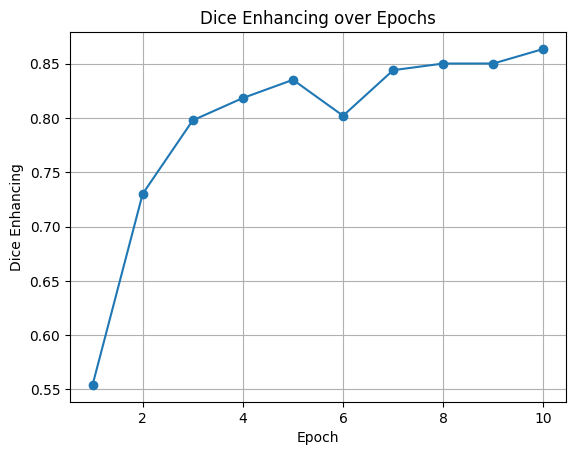

In [54]:
import matplotlib.pyplot as plt
import torch

def convert_to_numpy(data):
    if isinstance(data, list):
        return [convert_to_numpy(item) for item in data]
    elif isinstance(data, torch.Tensor):
        # Convert a 0-dim tensor to a Python number, else to a NumPy array.
        return data.detach().cpu().item() if data.ndim == 0 else data.detach().cpu().numpy()
    else:
        return data

# Convert the stored metrics to NumPy arrays/lists if they are tensors
epochs = convert_to_numpy(all_metrics["epoch"])
dice_values = convert_to_numpy(all_metrics["dice"])
precision_values = convert_to_numpy(all_metrics["precision"])
sensitivity_values = convert_to_numpy(all_metrics["sensitivity"])
specificity_values = convert_to_numpy(all_metrics["specificity"])
dice_nec_values = convert_to_numpy(all_metrics["dice_necrotic"])
dice_edema_values = convert_to_numpy(all_metrics["dice_edema"])
dice_enh_values = convert_to_numpy(all_metrics["dice_enhancing"])

metrics = {
    "Dice Coefficient": dice_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Specificity": specificity_values,
    "Dice Necrotic": dice_nec_values,
    "Dice Edema": dice_edema_values,
    "Dice Enhancing": dice_enh_values,
}

# Plot each metric over epochs
for label, values in metrics.items():
    plt.figure()
    plt.plot(epochs, values, marker='o')
    plt.title(f"{label} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.grid(True)
    plt.show()


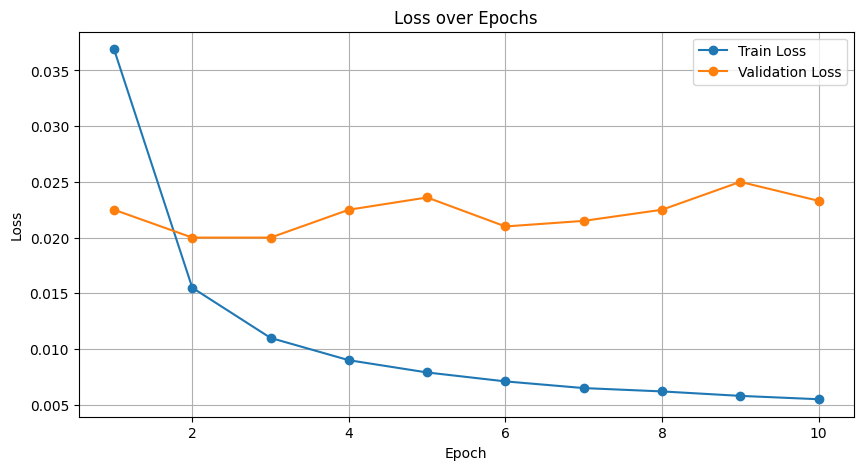

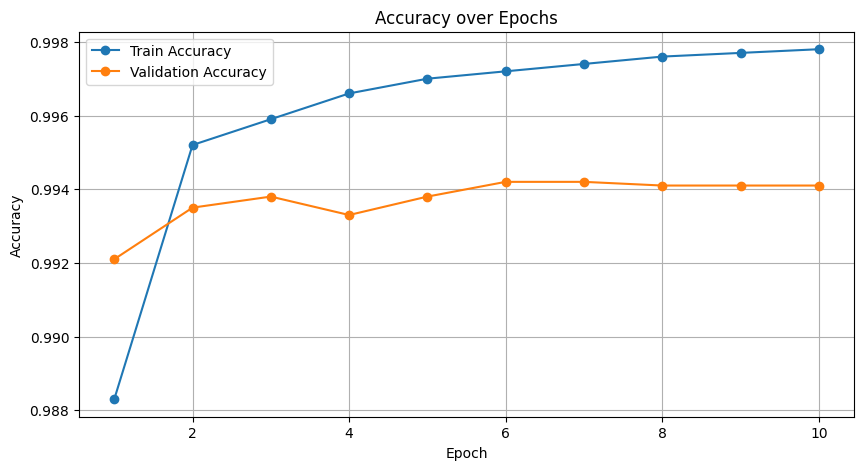

In [55]:
import matplotlib.pyplot as plt

# Based on the screenshot/logs you shared:
epochs = list(range(1, 11))

# Extracted from each "Epoch X/10 | Train Loss: ..., Train Acc: ..., Val Loss: ..., Val Acc: ..."
train_loss = [0.0369, 0.0155, 0.0110, 0.0090, 0.0079, 0.0071, 0.0065, 0.0062, 0.0058, 0.0055]
train_acc  = [0.9883, 0.9952, 0.9959, 0.9966, 0.9970, 0.9972, 0.9974, 0.9976, 0.9977, 0.9978]

val_loss   = [0.0225, 0.0200, 0.0200, 0.0225, 0.0236, 0.0210, 0.0215, 0.0225, 0.0250, 0.0233]
val_acc    = [0.9921, 0.9935, 0.9938, 0.9933, 0.9938, 0.9942, 0.9942, 0.9941, 0.9941, 0.9941]

# --- Plot: Loss ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot: Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
model = keras.models.load_model('my_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

We specify the path to our saved model and provide a dictionary of `custom_objects` to ensure that our custom metrics and loss functions are correctly recognized by Keras. Setting `compile=False` allows us to load the model architecture and weights without compiling it immediately, giving us the flexibility to adjust compilation settings if needed.

In [ ]:
history = pd.read_csv('training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# 12. Predict Tumor Segmentations

In [ ]:
# Compile a model and load our saved weights

import tensorflow as tensorflow
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('model_.10-0.031059.weights.h5')

This allows you to select and use the optimal model version for your specific needs.

---

Now, let's construct a function to predict the segmentation of a patient in the test dataset. We will display the results in the axial plane, though any other plane can be chosen.

In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
    return np.array(image)

In [ ]:
def loadSegmentation(seg_path, volume_slices=100, volume_start=0, img_size=128):
    """
    Loads the segmentation volume, returns shape = (volume_slices, img_size, img_size).
    """
    seg_data = nib.load(seg_path).get_fdata()

    Y = np.zeros((volume_slices, img_size, img_size), dtype=np.uint8)
    for i in range(volume_slices):
        slice_idx = i + volume_start
        # Resizing with INTER_NEAREST to preserve label integrity
        Y[i] = cv2.resize(seg_data[:, :, slice_idx], (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Convert label 4 to label 3, if needed
    Y[Y == 4] = 3
    return Y

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def showPredictsById(case, start_slice = 50):
    path = f"/Users/mel/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

### use this instead

In [ ]:
import os
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

###############################################################################
# Example: One-cell code replicating the logic of "showPredictsById" with a
# cleaner "predictByPath" approach. Assumes you already have:
#   1) A trained model in the variable 'model' (or load it inside this cell).
#   2) Certain global parameters (VOLUME_START_AT, IMG_SIZE, etc.) defined.
###############################################################################

# 1. Global parameters & label map (adjust as needed)
VOLUME_START_AT = 22
IMG_SIZE        = 128
VOLUME_SLICES   = 100

SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

# 2. Simple loader to build a 4D array for Flair + T1CE
def imageLoader(flair_path, t1ce_path, volume_slices=100, volume_start=22, img_size=128):
    """
    Loads Flair & T1CE from NIfTI, returns shape (volume_slices, img_size, img_size, 2).
    """
    flair_data = nib.load(flair_path).get_fdata()
    t1ce_data  = nib.load(t1ce_path).get_fdata()

    # Create container
    X = np.zeros((volume_slices, img_size, img_size, 2), dtype=np.float32)

    for i in range(volume_slices):
        z = volume_start + i
        # Flair channel
        X[i,:,:,0] = cv2.resize(flair_data[:,:,z], (img_size, img_size))
        # T1CE channel
        X[i,:,:,1] = cv2.resize(t1ce_data[:,:,z], (img_size, img_size))

    return X

# 3. Predict function that uses the loader, normalizes input, and calls 'model'
def predictByPath(patient_path, case_number):
    """
    - patient_path: folder path containing BraTS20_Training_{case_number} files
    - case_number: e.g. "355"
    Returns: predictions of shape (volume_slices, img_size, img_size, 4)
    """
    flair_path = os.path.join(patient_path, f'BraTS20_Training_{case_number}_flair.nii')
    t1ce_path  = os.path.join(patient_path, f'BraTS20_Training_{case_number}_t1ce.nii')

    # Build input
    X = imageLoader(flair_path, t1ce_path,
                    volume_slices=VOLUME_SLICES,
                    volume_start=VOLUME_START_AT,
                    img_size=IMG_SIZE)

    # Normalize to [0,1] if not zero
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    # Run inference
    preds = model.predict(X, verbose=0)  # shape: (100, 128, 128, 4)
    return preds

# 4. Show predictions similarly to "showPredictsById"
def showPredictsById(case, start_slice=60):
    """
    case: e.g. "355"
    start_slice: which slice from the loaded 100 slices to display
    Plots:
       - original Flair slice
       - ground truth
       - "all classes predicted"
       - Edema
       - Core
       - Enhancing
    in subplots(1,6).
    """
    # Path to the specific BraTS20_Training_{case} folder
    path = train_path

    # Load ground truth and original Flair volume for the background
    gt_path  = os.path.join(path, f'BraTS20_Training_{case}_seg.nii')
    flair_path = os.path.join(path, f'BraTS20_Training_{case}_flair.nii')

    gt_data    = nib.load(gt_path).get_fdata()
    orig_flair = nib.load(flair_path).get_fdata()

    # Predict
    p = predictByPath(path, case)  # shape (100, 128, 128, 4)
    core      = p[:,:,:,1]
    edema     = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    # Prepare figure
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # background slice from original Flair
    flair_slice = orig_flair[:, :, start_slice + VOLUME_START_AT]
    flair_slice_resized = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))

    # repeated for each of the 6 subplots
    for i in range(6):
        axarr[i].imshow(flair_slice_resized, cmap="gray", interpolation='none')
        axarr[i].axis('off')

    # Subplot 0: original flair
    axarr[0].title.set_text('Original image (Flair)')

    # Subplot 1: ground truth
    curr_gt = gt_data[:, :, start_slice + VOLUME_START_AT]
    curr_gt_resized = cv2.resize(curr_gt, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt_resized, cmap="Reds", alpha=0.3, interpolation='none')
    axarr[1].title.set_text('Ground truth')

    # Subplot 2: "all classes predicted" – show channels 1..4
    # p[start_slice] shape = (128,128,4). We'll slice out channels 1..4 => shape(128,128,3)
    # or we just overlay them in a single colormap
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", alpha=0.3, interpolation='none')
    axarr[2].title.set_text('All classes predicted')

    # Subplot 3: edema
    axarr[3].imshow(edema[start_slice], cmap="OrRd", alpha=0.3, interpolation='none')
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

    # Subplot 4: core
    axarr[4].imshow(core[start_slice], cmap="OrRd", alpha=0.3, interpolation='none')
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

    # Subplot 5: enhancing
    axarr[5].imshow(enhancing[start_slice], cmap="OrRd", alpha=0.3, interpolation='none')
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()

###############################################################################
# Usage:
#  - Make sure you have a loaded model in a variable called 'model'.
#  - Then call: showPredictsById("355")  # as an example
###############################################################################

# Example (commented out):
model = load_model("my_model.keras", compile=False)
showPredictsById("355", start_slice=60)

C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\2476337051.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_epoch_10.pth", m

AttributeError: 'ResidualUNet' object has no attribute 'predict'

C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\6106143.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_epoch_10.pth", map_lo

<Figure size 1800x5000 with 0 Axes>

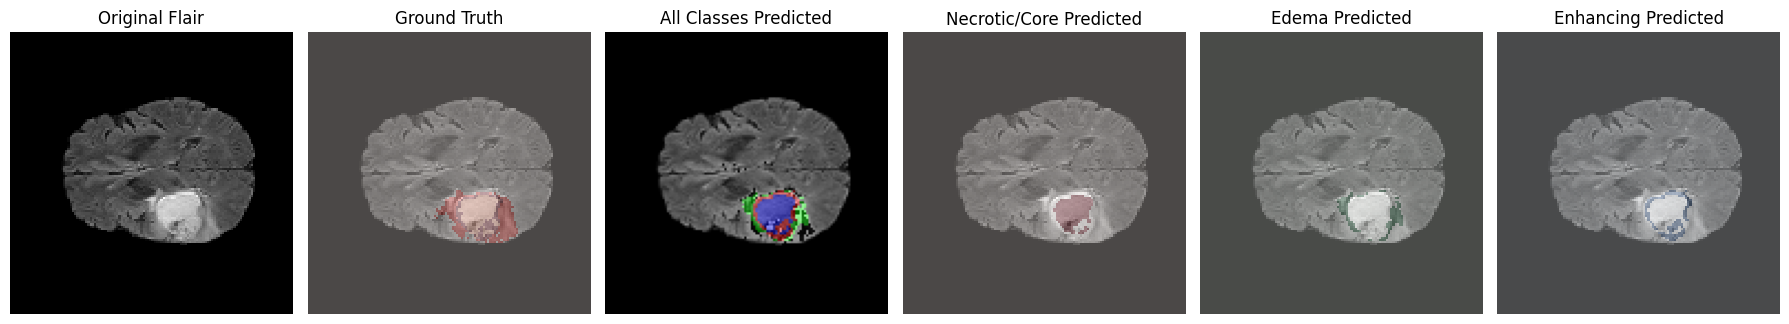

In [101]:
model = ResidualUNet(in_channels=2, out_channels=4, dropout=0.3).to(device)
model.load_state_dict(torch.load("model2_epoch_10.pth", map_location=device))
model.eval()

# -------------------------- DATA LOADER FUNCTIONS --------------------------
def load_volume(case_path, case):
    """
    Loads the Flair and T1CE volumes for a given case and returns a numpy array X
    of shape (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2).
    """
    flair_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    ce_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(ce_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2), dtype=np.float32)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return X

@torch.no_grad()
def predict_volume(case_path, case):
    """
    Loads the input volume, normalizes it, converts it to a PyTorch tensor,
    runs model inference, applies softmax, and returns the probabilities.
    Output shape: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
    """
    X = load_volume(case_path, case)
    max_val = np.max(X)
    if max_val > 0:
        X = X / max_val
    # Convert to tensor and rearrange dimensions: (N, H, W, C) -> (N, C, H, W)
    X_tensor = torch.from_numpy(X).permute(0, 3, 1, 2).to(device)
    logits = model(X_tensor)
    probs = F.softmax(logits, dim=1)
    # Rearrange back: (N, C, H, W) -> (N, H, W, C)
    probs = probs.permute(0, 2, 3, 1).cpu().numpy()
    return probs

def load_segmentation(case_path, case):
    """
    Loads the ground truth segmentation volume for a given case.
    Returns an array of shape (VOLUME_SLICES, IMG_SIZE, IMG_SIZE).
    """
    seg_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')
    seg_data = nib.load(seg_path).get_fdata()
    Y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    for j in range(VOLUME_SLICES):
        Y[j] = cv2.resize(seg_data[:, :, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    # Remap label 4 to 3 if present
    Y[Y == 4] = 3
    return Y

# -------------------------- COLORIZATION FUNCTION --------------------------
def colorize_segmentation(seg_mask):
    """
    Converts a discrete segmentation mask (H, W) with values {0,1,2,3} into an RGB image.
    """
    color_map = {
        0: (0, 0, 0),       # background: black
        1: (255, 0, 0),     # necrotic/core: red
        2: (0, 255, 0),     # edema: green
        3: (0, 0, 255)      # enhancing: blue
    }
    h, w = seg_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        rgb[seg_mask == cls] = color
    return rgb

# -------------------------- VISUALIZATION FUNCTION --------------------------
def visualize_case(case, start_slice=50):
    """
    Visualizes one slice from a given case.
    Displays six subplots:
      0. Original Flair slice.
      1. Ground Truth overlay.
      2. Multi-color predicted segmentation overlay.
      3. NECROTIC/CORE (class 1) binary mask overlay.
      4. EDEMA (class 2) binary mask overlay.
      5. ENHANCING (class 3) binary mask overlay.
    """
    # Set your base path where the BraTS case folders reside
    base_path = "C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    case_path = os.path.join(base_path, f'BraTS20_Training_{case}')

    # Load original Flair volume and ground truth segmentation
    flair_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair_vol = nib.load(flair_path).get_fdata()
    gt = load_segmentation(case_path, case)

    # Get predictions from the model
    probs = predict_volume(case_path, case)  # shape: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
    pred_labels = np.argmax(probs, axis=-1)    # Discrete segmentation

    # Select a slice (apply offset for original volumes)
    slice_idx = start_slice
    flair_slice = cv2.resize(flair_vol[:, :, slice_idx+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    gt_slice = cv2.resize(gt[slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    pred_slice = cv2.resize(pred_labels[slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Create a multi-color overlay for the prediction
    seg_rgb = colorize_segmentation(pred_slice)
    flair_3ch = cv2.cvtColor(flair_slice.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    blended = cv2.addWeighted(flair_3ch, 0.6, seg_rgb, 0.4, 0)

    # Create binary masks for each tumor class (scale 0-255)
    mask_core = ((pred_slice == 1).astype(np.uint8)) * 255   # Necrotic/Core
    mask_edema = ((pred_slice == 2).astype(np.uint8)) * 255     # Edema
    mask_enhancing = ((pred_slice == 3).astype(np.uint8)) * 255 # Enhancing

    # Plot six subplots
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # Subplot 0: Original Flair
    axarr[0].imshow(flair_slice, cmap="gray", interpolation='none')
    axarr[0].set_title("Original Flair")
    axarr[0].axis('off')

    # Subplot 1: Ground Truth overlay (using red overlay)
    axarr[1].imshow(flair_slice, cmap="gray", interpolation='none')
    axarr[1].imshow(gt_slice, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title("Ground Truth")
    axarr[1].axis('off')

    # Subplot 2: Multi-color predicted segmentation overlay
    axarr[2].imshow(blended[..., ::-1])  # Convert BGR to RGB for matplotlib
    axarr[2].set_title("All Classes Predicted")
    axarr[2].axis('off')

    # Subplot 3: NECROTIC/CORE predicted overlay
    axarr[3].imshow(flair_slice, cmap="gray", interpolation='none')
    axarr[3].imshow(mask_core, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[3].set_title("Necrotic/Core Predicted")
    axarr[3].axis('off')

    # Subplot 4: EDEMA predicted overlay
    axarr[4].imshow(flair_slice, cmap="gray", interpolation='none')
    axarr[4].imshow(mask_edema, cmap="Greens", interpolation='none', alpha=0.3)
    axarr[4].set_title("Edema Predicted")
    axarr[4].axis('off')

    # Subplot 5: ENHANCING predicted overlay
    axarr[5].imshow(flair_slice, cmap="gray", interpolation='none')
    axarr[5].imshow(mask_enhancing, cmap="Blues", interpolation='none', alpha=0.3)
    axarr[5].set_title("Enhancing Predicted")
    axarr[5].axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------- USAGE EXAMPLE --------------------------
# Adjust the case number as needed, for example "355":
visualize_case("060", start_slice=50)

C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\1005881553.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_epoch_10.pth", ma

<Figure size 1800x5000 with 0 Axes>

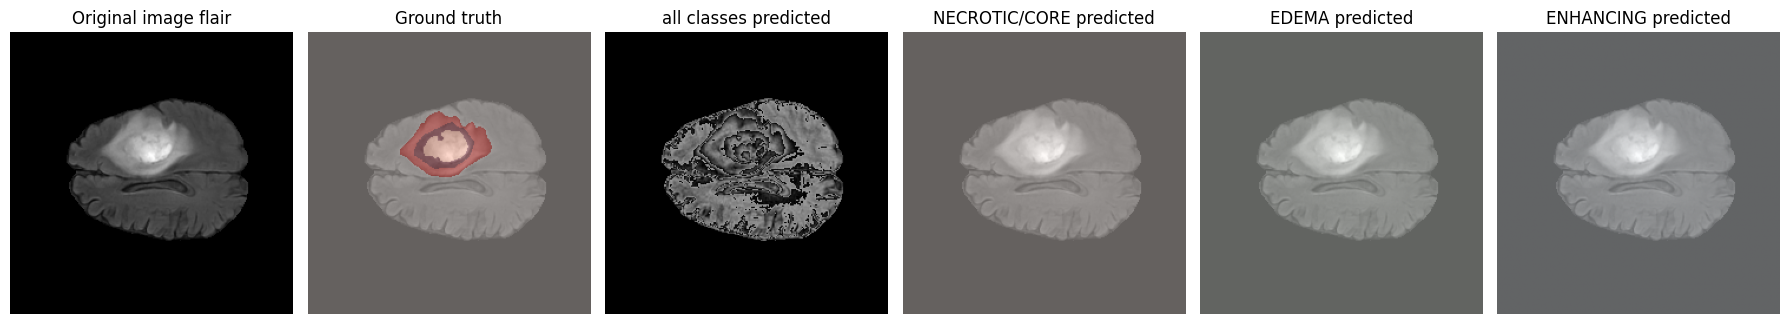

In [115]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt

###############################################################################
# GLOBAL SETTINGS
###############################################################################
# Model expects 128x128 inputs, so we must resize each slice to 128x128 for inference
MODEL_IMG_SIZE = 128
VOLUME_START_AT = 22  # offset into the volume if needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4-class segmentation: {0: background, 1: core, 2: edema, 3: enhancing}
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}


model = ResidualUNet(in_channels=2, out_channels=4, dropout=0.3).to(device)
model.load_state_dict(torch.load("model2_epoch_10.pth", map_location=device))
model.eval()

###############################################################################
# HELPER: colorize_segmentation for multi-color overlay
###############################################################################
def colorize_segmentation(seg_mask):
    """
    seg_mask: 2D array with values in {0,1,2,3}.
    Returns an RGB image (H, W, 3) with each class in a distinct color.
    """
    color_map = {
        0: (0, 0, 0),       # background: black
        1: (255, 0, 0),     # necrotic/core: red
        2: (0, 255, 0),     # edema: green
        3: (0, 0, 255)      # enhancing: blue
    }
    h, w = seg_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, (r, g, b) in color_map.items():
        rgb[seg_mask == cls] = (r, g, b)
    return rgb

###############################################################################
# HELPER: predict_slice
###############################################################################
@torch.no_grad()
def predict_slice(flair_slice, t1ce_slice):
    """
    1) Resizes each channel to MODEL_IMG_SIZE (128x128).
    2) Normalizes (divides by max).
    3) Feeds the slice to the model, applies softmax + argmax.
    4) Upscales the result back to the original resolution (nearest-neighbor).
    """
    original_h, original_w = flair_slice.shape

    # Resize to 128x128
    flair_resized = cv2.resize(flair_slice, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    t1ce_resized  = cv2.resize(t1ce_slice,  (MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # Stack => shape (1,2,128,128), then normalize
    X = np.stack([flair_resized, t1ce_resized], axis=0)[np.newaxis, ...]
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    # Inference
    X_tensor = torch.from_numpy(X).float().to(device)
    logits   = model(X_tensor)                  # (1,4,128,128)
    probs    = F.softmax(logits, dim=1)         # (1,4,128,128)
    pred     = torch.argmax(probs, dim=1)[0]    # (128,128)

    # Upscale to original shape
    pred_up = cv2.resize(pred.cpu().numpy().astype(np.uint8),
                         (original_w, original_h),
                         interpolation=cv2.INTER_NEAREST)
    return pred_up

###############################################################################
# MAIN FUNCTION: visualize_case
###############################################################################
def visualize_case(case="355", slice_idx=60):
    """
    1) Loads Flair, T1CE, and seg at original resolution.
    2) Predicts a single slice (resized to 128x128, then upsampled).
    3) Creates multi-color overlay & separate overlays.
    """
    base_path = "C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    case_path = os.path.join(base_path, f"BraTS20_Training_{case}")

    # Load volumes
    flair_vol = nib.load(os.path.join(case_path, f"BraTS20_Training_{case}_flair.nii")).get_fdata()
    t1ce_vol  = nib.load(os.path.join(case_path, f"BraTS20_Training_{case}_t1ce.nii")).get_fdata()
    seg_vol   = nib.load(os.path.join(case_path, f"BraTS20_Training_{case}_seg.nii")).get_fdata()

    # Adjust label 4 -> 3 if needed
    seg_vol[seg_vol == 4] = 3

    # Pick the slice
    z = slice_idx + VOLUME_START_AT
    flair_slice = flair_vol[:, :, z]
    t1ce_slice  = t1ce_vol[:, :, z]
    seg_slice   = seg_vol[:, :, z]

    # Predict
    pred_mask = predict_slice(flair_slice, t1ce_slice)

    # Build multi-color overlay
    seg_rgb   = colorize_segmentation(pred_mask)
    flair_3ch = cv2.cvtColor(flair_slice.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    blended   = cv2.addWeighted(flair_3ch, 0.6, seg_rgb, 0.4, 0)

    # Build separate binary masks for each class
    mask_core       = (pred_mask == 1).astype(np.uint8)*255
    mask_edema      = (pred_mask == 2).astype(np.uint8)*255
    mask_enhancing  = (pred_mask == 3).astype(np.uint8)*255

    # PLOTTING
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # 0) Original Flair
    axarr[0].imshow(flair_slice, cmap="gray")
    axarr[0].set_title("Original image flair")
    axarr[0].axis('off')

    # 1) Ground Truth
    axarr[1].imshow(flair_slice, cmap="gray")
    axarr[1].imshow(seg_slice, cmap="Reds", alpha=0.4)
    axarr[1].set_title("Ground truth")
    axarr[1].axis('off')

    # 2) All classes predicted (multi-color overlay)
    axarr[2].imshow(blended[..., ::-1])  # BGR->RGB
    axarr[2].set_title("all classes predicted")
    axarr[2].axis('off')

    # 3) Necrotic/Core predicted
    axarr[3].imshow(flair_slice, cmap="gray")
    axarr[3].imshow(mask_core, cmap="Reds", alpha=0.4)
    axarr[3].set_title("NECROTIC/CORE predicted")
    axarr[3].axis('off')

    # 4) Edema predicted
    axarr[4].imshow(flair_slice, cmap="gray")
    axarr[4].imshow(mask_edema, cmap="Greens", alpha=0.4)
    axarr[4].set_title("EDEMA predicted")
    axarr[4].axis('off')

    # 5) Enhancing predicted
    axarr[5].imshow(flair_slice, cmap="gray")
    axarr[5].imshow(mask_enhancing, cmap="Blues", alpha=0.4)
    axarr[5].set_title("ENHANCING predicted")
    axarr[5].axis('off')

    plt.tight_layout()
    plt.show()

###############################################################################
# USAGE EXAMPLE
###############################################################################
# 1) Adjust 'base_path' inside visualize_case to match your environment.
# 2) Then call:
visualize_case(case="355", slice_idx=70)
#    or pick a slice index with a nice, large tumor region.


In [105]:
probs = predict_volume(r"C:\Users\Melisa\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350", "350")

In [107]:
slice_idx = 50  # Must be between 0 and 99
slice_probs = probs[slice_idx]  # Now slice_probs is of shape (IMG_SIZE, IMG_SIZE, 4)
y, x = 100, 100  # Coordinates within the 128x128 slice (since IMG_SIZE=128)
print("Background probability:", slice_probs[y, x, 0])
print("Core probability:", slice_probs[y, x, 1])
print("Edema probability:", slice_probs[y, x, 2])
print("Enhancing probability:", slice_probs[y, x, 3])

Background probability: 1.0
Core probability: 8.75866e-32
Edema probability: 1.1813625e-29
Enhancing probability: 1.2429949e-26


In [108]:
slice_probs = probs[50]  # for slice index 50 (assuming IMG_SIZE is 128)
region = slice_probs[90:110, 90:110, :]  # a 20x20 region
max_probs = region.reshape(-1, region.shape[-1]).max(axis=0)
print("Max probabilities in region:", max_probs)


Max probabilities in region: [1.0000000e+00 3.4648425e-17 2.8660501e-11 1.2693506e-13]


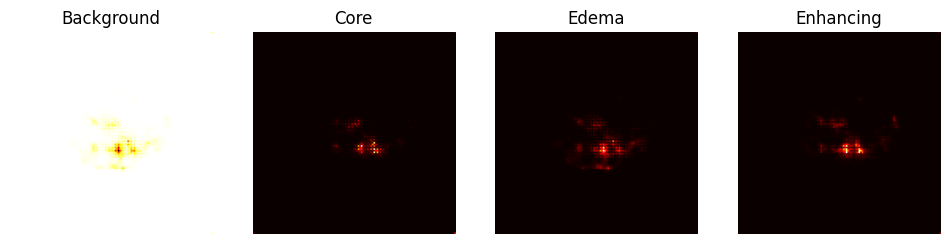

In [111]:
import matplotlib.pyplot as plt

slice_probs = probs[50]  # choose slice index 50 for instance
plt.figure(figsize=(12, 3))
for i, label in enumerate(["Background", "Core", "Edema", "Enhancing"]):
    plt.subplot(1, 4, i+1)
    plt.imshow(slice_probs[:, :, i], cmap='hot')
    plt.title(label)
    plt.axis('off')
plt.show()


C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\1483953513.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_epoch_10.pth", ma

<Figure size 1800x5000 with 0 Axes>

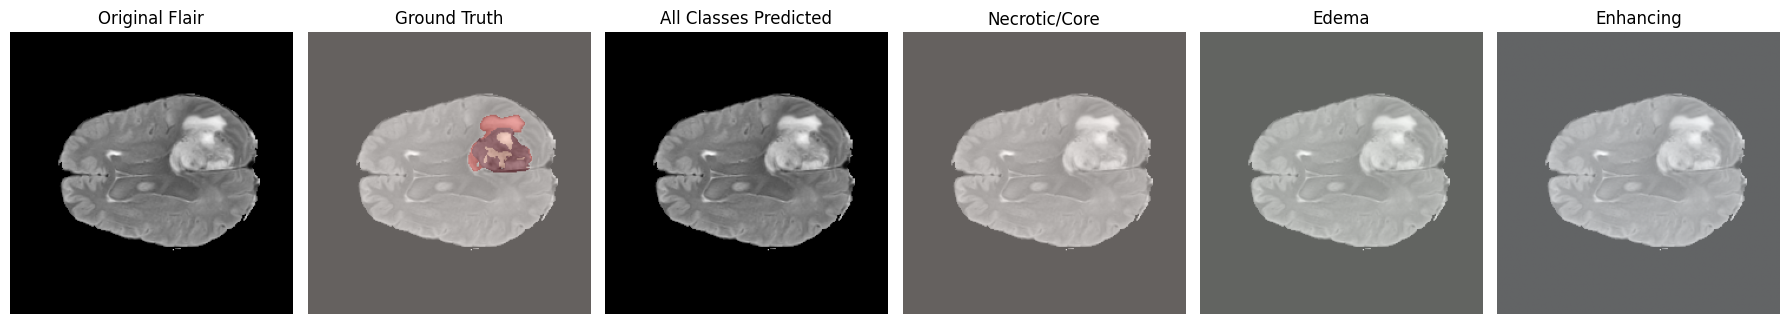

In [110]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt

###############################################################################
# GLOBAL SETTINGS
###############################################################################
VOLUME_START_AT = 22     # offset into the volume
MODEL_IMG_SIZE  = 128    # model input size (if your U-Net is trained on 128×128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}

# Instantiate and load your model
model = ResidualUNet(in_channels=2, out_channels=4, dropout=0.3).to(device)
model.load_state_dict(torch.load("model2_epoch_10.pth", map_location=device))
model.eval()

###############################################################################
# HELPERS
###############################################################################
def colorize_segmentation(seg_mask):
    """
    seg_mask: 2D array with {0,1,2,3}
    Returns an RGB image (H, W, 3) with each class a distinct color.
    """
    color_map = {
        0: (0, 0, 0),       # background -> black
        1: (255, 0, 0),     # core -> red
        2: (0, 255, 0),     # edema -> green
        3: (0, 0, 255)      # enhancing -> blue
    }
    h, w = seg_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, (r, g, b) in color_map.items():
        rgb[seg_mask == cls] = (r, g, b)
    return rgb

@torch.no_grad()
def predict_slice(flair_slice, t1ce_slice):
    """
    1) Resizes to MODEL_IMG_SIZE for the model,
    2) Runs inference (softmax -> argmax),
    3) Upscales predicted mask back to the original slice shape (nearest-neighbor).
    """
    orig_h, orig_w = flair_slice.shape
    # Resize both channels to 128×128 for the model
    flair_resized = cv2.resize(flair_slice, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    ce_resized    = cv2.resize(t1ce_slice,  (MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # Stack into shape (1,2,128,128), normalize
    X = np.stack([flair_resized, ce_resized], axis=0)[np.newaxis, ...]
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    X_tensor = torch.from_numpy(X).float().to(device)  # (1,2,128,128)
    logits   = model(X_tensor)                         # (1,4,128,128)
    probs    = F.softmax(logits, dim=1)               # (1,4,128,128)
    pred     = torch.argmax(probs, dim=1).cpu().numpy()  # (1,128,128)
    pred_2d  = pred[0]                                # (128,128)

    # Upscale back to original shape
    pred_original = cv2.resize(
        pred_2d.astype(np.uint8),
        (orig_w, orig_h),
        interpolation=cv2.INTER_NEAREST
    )
    return pred_original

###############################################################################
# MAIN VISUALIZATION
###############################################################################
def visualize_case(case="355", slice_idx=60):
    """
    1) Loads Flair/T1CE/Seg at original resolution.
    2) Predicts the slice in 128×128, upscales back.
    3) Overlays multi-color mask with transparent background on the Flair slice.
    4) Also shows each class individually.
    """
    base_path = "C:/Users/Melisa/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # <-- Adjust
    case_path = os.path.join(base_path, f"BraTS20_Training_{case}")

    # Load volumes
    flair_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    ce_path    = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    seg_path   = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')

    flair_vol = nib.load(flair_path).get_fdata()
    ce_vol    = nib.load(ce_path).get_fdata()
    seg_vol   = nib.load(seg_path).get_fdata()

    # Slice selection (plus offset)
    z = slice_idx + VOLUME_START_AT
    flair_slice = flair_vol[:, :, z]
    ce_slice    = ce_vol[:, :, z]
    seg_slice   = seg_vol[:, :, z]
    # Convert label 4 -> 3 if needed
    seg_slice[seg_slice == 4] = 3

    # Predict segmentation for this slice
    pred_mask = predict_slice(flair_slice, ce_slice)  # shape ~ (240,240)

    # Create a color overlay with transparent background for class=0
    color_seg = colorize_segmentation(pred_mask)
    alpha_map = np.zeros_like(pred_mask, dtype=np.float32)
    alpha_map[pred_mask > 0] = 0.6  # Show color where class != 0

    # Convert flair to 3 channels for overlay
    flair_3ch = cv2.cvtColor(flair_slice.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # We'll overlay in matplotlib using the alpha_map
    # But for the individual classes, let's build separate masks
    mask_core       = ((pred_mask == 1).astype(np.uint8) * 255)
    mask_edema      = ((pred_mask == 2).astype(np.uint8) * 255)
    mask_enhancing  = ((pred_mask == 3).astype(np.uint8) * 255)

    # Plot subplots
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # 0. Original Flair
    axarr[0].imshow(flair_slice, cmap="gray")
    axarr[0].set_title("Original Flair")
    axarr[0].axis("off")

    # 1. Ground Truth
    axarr[1].imshow(flair_slice, cmap="gray")
    axarr[1].imshow(seg_slice, cmap="Reds", alpha=0.4)
    axarr[1].set_title("Ground Truth")
    axarr[1].axis("off")

    # 2. All classes predicted (multi-color with transparent background)
    # Show flair in grayscale, then color overlay
    axarr[2].imshow(flair_slice, cmap="gray")
    # Convert color_seg (BGR) to RGB for matplotlib
    color_seg_rgb = color_seg[..., ::-1]  # if we want to treat color_seg as BGR
    # But color_seg is actually RGB in the function. If you see weird colors, swap.
    # We'll assume color_seg is already RGB from colorize_segmentation.
    # We'll build a per-pixel alpha array
    axarr[2].imshow(color_seg, alpha=alpha_map)
    axarr[2].set_title("All Classes Predicted")
    axarr[2].axis("off")

    # 3. Necrotic/Core
    axarr[3].imshow(flair_slice, cmap="gray")
    axarr[3].imshow(mask_core, cmap="Reds", alpha=0.4)
    axarr[3].set_title("Necrotic/Core")
    axarr[3].axis("off")

    # 4. Edema
    axarr[4].imshow(flair_slice, cmap="gray")
    axarr[4].imshow(mask_edema, cmap="Greens", alpha=0.4)
    axarr[4].set_title("Edema")
    axarr[4].axis("off")

    # 5. Enhancing
    axarr[5].imshow(flair_slice, cmap="gray")
    axarr[5].imshow(mask_enhancing, cmap="Blues", alpha=0.4)
    axarr[5].set_title("Enhancing")
    axarr[5].axis("off")

    plt.tight_layout()
    plt.show()

###############################################################################
# USAGE EXAMPLE:
# 1) Update 'base_path' in visualize_case to point to your actual data folder.
# 2) Then call:
visualize_case(case="350", slice_idx=60)
###############################################################################


C:\Users\Melisa\AppData\Local\Temp\ipykernel_17784\876350279.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model2_epoch_10.pth", map

<Figure size 1800x5000 with 0 Axes>

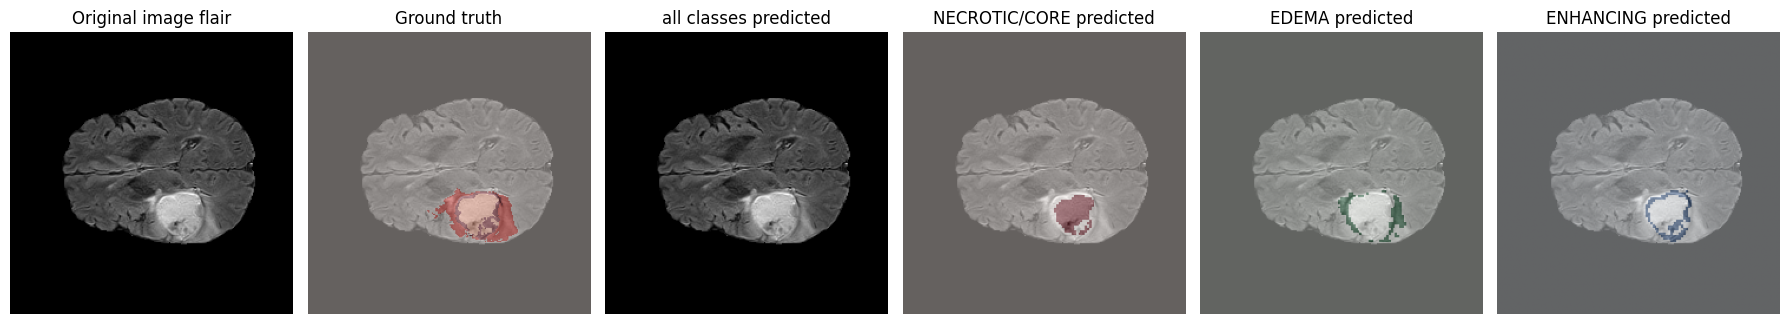

In [117]:
import os
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

###############################################################################
# 1) GLOBAL SETTINGS
###############################################################################
MODEL_IMG_SIZE  = 128   # Model was trained on 128x128
VOLUME_START_AT = 22    # If your volumes start at slice index 22
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}

###############################################################################
# 2) COLOR & ALPHA FUNCTIONS
###############################################################################
def colorize_segmentation(seg_mask):
    """
    seg_mask: 2D array with values in {0,1,2,3}.
    Returns (H, W, 3) with each class in a distinct color:
      0 -> black
      1 -> red
      2 -> green
      3 -> blue
    """
    color_map = {
        0: (0,   0,   0),    # background
        1: (255, 0,   0),    # core
        2: (0,   255, 0),    # edema
        3: (0,   0,   255)   # enhancing
    }
    h, w = seg_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, (r, g, b) in color_map.items():
        rgb[seg_mask == cls] = (r, g, b)
    return rgb

def make_alpha_map(seg_mask, alpha_value=0.4):
    """
    seg_mask: 2D array in {0,1,2,3}
    alpha_value: float in [0,1], e.g. 0.4
    Returns a 2D array of shape (H,W) with 0 for background, alpha_value for tumor.
    """
    alpha = np.zeros_like(seg_mask, dtype=np.float32)
    alpha[seg_mask > 0] = alpha_value
    return alpha


model = ResidualUNet(in_channels=2, out_channels=4, dropout=0.3).to(device)
model.load_state_dict(torch.load("model2_epoch_10.pth", map_location=device))
model.eval()

###############################################################################
# 4) PREDICTION FOR ONE SLICE
###############################################################################
@torch.no_grad()
def predict_slice(flair_slice, t1ce_slice):
    """
    1. Resize to MODEL_IMG_SIZE x MODEL_IMG_SIZE.
    2. Normalize by max intensity.
    3. Model inference -> softmax -> argmax.
    4. Upscale back to original resolution with nearest-neighbor.
    Returns a 2D array (H,W) in {0,1,2,3}.
    """
    orig_h, orig_w = flair_slice.shape

    # Resize to 128x128 (or your model input)
    flair_resized = cv2.resize(flair_slice, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    t1ce_resized  = cv2.resize(t1ce_slice,  (MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # Stack => shape (1,2,128,128), then normalize
    X = np.stack([flair_resized, t1ce_resized], axis=0)[np.newaxis, ...]
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    # Convert to tensor
    X_tensor = torch.from_numpy(X).float().to(device)  # (1,2,128,128)

    # Inference
    logits = model(X_tensor)            # (1,4,128,128)
    probs  = F.softmax(logits, dim=1)   # (1,4,128,128)
    pred   = torch.argmax(probs, dim=1) # (1,128,128)

    # Upscale to original slice size
    pred_up = cv2.resize(pred[0].cpu().numpy().astype(np.uint8),
                         (orig_w, orig_h),
                         interpolation=cv2.INTER_NEAREST)
    return pred_up

###############################################################################
# 5) MAIN VISUALIZATION
###############################################################################
def visualize_case(case="355", slice_idx=60):
    """
    1) Load Flair, T1CE, seg at original resolution.
    2) Predict the slice -> discrete mask in {0,1,2,3}.
    3) Overlay multi-color mask with alpha for tumor classes.
    4) Also show separate class overlays.
    """
    base_path = r"C:\Users\Melisa\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
    case_path = os.path.join(base_path, f"BraTS20_Training_{case}")

    # Load volumes
    flair_path = os.path.join(case_path, f"BraTS20_Training_{case}_flair.nii")
    t1ce_path  = os.path.join(case_path, f"BraTS20_Training_{case}_t1ce.nii")
    seg_path   = os.path.join(case_path, f"BraTS20_Training_{case}_seg.nii")

    flair_vol = nib.load(flair_path).get_fdata()
    t1ce_vol  = nib.load(t1ce_path).get_fdata()
    seg_vol   = nib.load(seg_path).get_fdata()

    # Convert label 4 -> 3 if present
    seg_vol[seg_vol == 4] = 3

    # Select the slice (with offset)
    z = slice_idx + VOLUME_START_AT
    flair_slice = flair_vol[:, :, z]
    t1ce_slice  = t1ce_vol[:, :, z]
    seg_slice   = seg_vol[:, :, z]

    # Predict
    pred_mask = predict_slice(flair_slice, t1ce_slice)

    # Convert to multi-color overlay
    seg_rgb = colorize_segmentation(pred_mask)
    alpha_map = make_alpha_map(pred_mask, alpha_value=0.4)

    # Convert flair to 3 channels
    flair_3ch = cv2.cvtColor(flair_slice.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Build separate binary masks
    core_mask       = (pred_mask == 1).astype(np.uint8)*255
    edema_mask      = (pred_mask == 2).astype(np.uint8)*255
    enhancing_mask  = (pred_mask == 3).astype(np.uint8)*255

    # PLOT
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # 0) Original Flair
    axarr[0].imshow(flair_slice, cmap="gray")
    axarr[0].set_title("Original image flair")
    axarr[0].axis('off')

    # 1) Ground Truth
    axarr[1].imshow(flair_slice, cmap="gray")
    axarr[1].imshow(seg_slice, cmap="Reds", alpha=0.4)
    axarr[1].set_title("Ground truth")
    axarr[1].axis('off')

    # 2) All classes predicted (multi-color overlay)
    axarr[2].imshow(flair_slice, cmap="gray")
    axarr[2].imshow(seg_rgb, alpha=alpha_map)  # black=0 => transparent
    axarr[2].set_title("all classes predicted")
    axarr[2].axis('off')

    # 3) Necrotic/Core predicted
    axarr[3].imshow(flair_slice, cmap="gray")
    axarr[3].imshow(core_mask, cmap="Reds", alpha=0.4)
    axarr[3].set_title("NECROTIC/CORE predicted")
    axarr[3].axis('off')

    # 4) Edema predicted
    axarr[4].imshow(flair_slice, cmap="gray")
    axarr[4].imshow(edema_mask, cmap="Greens", alpha=0.4)
    axarr[4].set_title("EDEMA predicted")
    axarr[4].axis('off')

    # 5) Enhancing predicted
    axarr[5].imshow(flair_slice, cmap="gray")
    axarr[5].imshow(enhancing_mask, cmap="Blues", alpha=0.4)
    axarr[5].set_title("ENHANCING predicted")
    axarr[5].axis('off')

    plt.tight_layout()
    plt.show()

###############################################################################
# USAGE EXAMPLE
###############################################################################
# Once you run this entire cell, you can call:
visualize_case(case="060", slice_idx=50)
# or some other slice with a prominent tumor to get a multi-color overlay.


In [91]:
import nibabel as nib
import cv2
import numpy as np

# Load the volumes from your .nii files
flair_vol = nib.load(r"C:\Users\Melisa\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii").get_fdata()  # e.g. shape (240, 240, 155)
ce_vol    = nib.load(r"C:\Users\Melisa\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii").get_fdata()

# Then select the slice
slice_idx = 60
flair_slice = flair_vol[:, :, slice_idx]
ce_slice    = ce_vol[:, :, slice_idx]

# Now you can predict
pred_slice = predict_slice(flair_slice, ce_slice)
pred_slice = predict_slice(flair_slice, ce_slice)
unique_vals, counts = np.unique(pred_slice, return_counts=True)
print(dict(zip(unique_vals, counts)))


{np.uint8(0): np.int64(57600)}


In [ ]:
showPredictsById(case=test_ids[0][-3:])

In [ ]:
showPredictsById(case=test_ids[10][-3:])

In [ ]:
showPredictsById(case=test_ids[8][-3:])

In [ ]:
showPredictsById(case=test_ids[3][-3:])

In [ ]:
showPredictsById(case=test_ids[9][-3:])

In [ ]:
showPredictsById(case=test_ids[11][-3:])

In [ ]:
showPredictsById(case=test_ids[6][-3:])

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

In [ ]:
show_predicted_segmentations(test_ids, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(test_ids, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(test_ids, 65, cmap, norm)

In [ ]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

# 13. Evaluation

Let's call the `evaluate()` function to evaluate the performance of our model on our test dataset:

In [ ]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")